In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cpu device


In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

])

# Download CIFAR-10 data
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

# Split the training data into training and validation subsets
train_size = int(0.8 * len(full_trainset))  # Use 80% for training
valid_size = len(full_trainset) - train_size  # Use the rest for validation

trainset, validset = torch.utils.data.random_split(full_trainset, [train_size, valid_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                          shuffle=False, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
print('Number of training images: ', len(trainset))
print('Number of validation images: ', len(validset))
print('Number of test images: ', len(testset))

#Print classes and index
print(testloader.dataset.class_to_idx)

def get_name_from_index(index):
    for name, num in testloader.dataset.class_to_idx.items():
        if num == index:
            return name


Number of training images:  40000
Number of validation images:  10000
Number of test images:  10000
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [6]:
class VGGStyleModel(nn.Module):
    def __init__(self):
        super(VGGStyleModel, self).__init__()

        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )

        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),  # assuming input size is 32x32
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),  # assuming a classification task with 10 classes
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output from conv layers
        x = self.fc_layers(x)
        return x


In [7]:
# Initialize model, loss function, and optimizer
model = VGGStyleModel().to(device)  # Move model to GPU
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training settings
EPOCHS = 20
train_losses = []
train_accs = []
valid_losses = []
val_accs = []

#best_valid_loss = float('inf')  # Initialize with infinity to ensure any loss is smaller
#best_model_wts = None  # To store best model weights

print("Starting training...")


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct_train = 0  # To calculate training accuracy

    for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        #print(f"inputs: {inputs[0].shape}")
        #print(f"labels: {labels[0]}")
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        #print(f"outputs: {outputs.shape}")
        #print one output
        #print(f"outputs: {outputs}")
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate training accuracy
        preds = torch.argmax(outputs, dim=1)
        #print(f"preds: {preds}")

        correct_train += (preds == labels).sum().item()


    train_losses.append(train_loss/len(trainloader))
    train_acc = correct_train / len(trainloader.dataset)
    train_accs.append(train_acc)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0  # To calculate validation accuracy

    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = loss_fn(outputs, labels)
            valid_loss += loss.item()

            # Calculate validation accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_valid += (preds == labels).sum().item()

    valid_losses.append(valid_loss/len(validloader))
    valid_acc = correct_valid / len(validloader.dataset)
    val_accs.append(valid_acc)

    # Save the model if it has a lower validation loss than the best model seen so far
    #if valid_losses[-1] < best_valid_loss:
    #    best_valid_loss = valid_losses[-1]
    #    best_model_wts = model.state_dict().copy()

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_acc:.4f}")

# Load the best model weights
#model.load_state_dict(best_m
#Epoch 10/20 - Train Loss: 0.2605, Train Acc: 0.9077, Valid Loss: 0.9871, Valid Acc: 0.7476

Starting training...


Epoch 1/20: 100%|██████████| 1250/1250 [00:27<00:00, 44.65batch/s]


Epoch 1/20 - Train Loss: 1.7504, Train Acc: 0.3492, Valid Loss: 1.3071, Valid Acc: 0.5212


Epoch 2/20: 100%|██████████| 1250/1250 [00:19<00:00, 65.62batch/s]


Epoch 2/20 - Train Loss: 1.3286, Train Acc: 0.5194, Valid Loss: 1.1306, Valid Acc: 0.5937


Epoch 3/20: 100%|██████████| 1250/1250 [00:19<00:00, 65.74batch/s]


Epoch 3/20 - Train Loss: 1.1506, Train Acc: 0.5916, Valid Loss: 0.9897, Valid Acc: 0.6493


Epoch 4/20: 100%|██████████| 1250/1250 [00:19<00:00, 64.51batch/s]


Epoch 4/20 - Train Loss: 1.0566, Train Acc: 0.6268, Valid Loss: 0.9308, Valid Acc: 0.6666


Epoch 5/20: 100%|██████████| 1250/1250 [00:20<00:00, 60.10batch/s]


Epoch 5/20 - Train Loss: 0.9818, Train Acc: 0.6562, Valid Loss: 0.8603, Valid Acc: 0.6960


Epoch 6/20: 100%|██████████| 1250/1250 [00:20<00:00, 61.88batch/s]


Epoch 6/20 - Train Loss: 0.9382, Train Acc: 0.6709, Valid Loss: 0.8207, Valid Acc: 0.7167


Epoch 7/20: 100%|██████████| 1250/1250 [00:19<00:00, 63.87batch/s]


Epoch 7/20 - Train Loss: 0.8952, Train Acc: 0.6869, Valid Loss: 0.7852, Valid Acc: 0.7276


Epoch 8/20: 100%|██████████| 1250/1250 [00:19<00:00, 65.45batch/s]


Epoch 8/20 - Train Loss: 0.8736, Train Acc: 0.6955, Valid Loss: 0.7793, Valid Acc: 0.7275


Epoch 9/20: 100%|██████████| 1250/1250 [00:18<00:00, 67.12batch/s]


Epoch 9/20 - Train Loss: 0.8467, Train Acc: 0.7048, Valid Loss: 0.7526, Valid Acc: 0.7361


Epoch 10/20: 100%|██████████| 1250/1250 [00:19<00:00, 63.88batch/s]


Epoch 10/20 - Train Loss: 0.8233, Train Acc: 0.7147, Valid Loss: 0.7802, Valid Acc: 0.7305


Epoch 11/20: 100%|██████████| 1250/1250 [00:19<00:00, 64.55batch/s]


Epoch 11/20 - Train Loss: 0.8061, Train Acc: 0.7224, Valid Loss: 0.7198, Valid Acc: 0.7531


Epoch 12/20: 100%|██████████| 1250/1250 [00:18<00:00, 67.08batch/s]


Epoch 12/20 - Train Loss: 0.7960, Train Acc: 0.7258, Valid Loss: 0.7109, Valid Acc: 0.7539


Epoch 13/20: 100%|██████████| 1250/1250 [00:18<00:00, 65.87batch/s]


Epoch 13/20 - Train Loss: 0.7748, Train Acc: 0.7317, Valid Loss: 0.7169, Valid Acc: 0.7539


Epoch 14/20: 100%|██████████| 1250/1250 [00:18<00:00, 67.80batch/s]


Epoch 14/20 - Train Loss: 0.7657, Train Acc: 0.7380, Valid Loss: 0.7376, Valid Acc: 0.7485


Epoch 15/20:  49%|████▉     | 613/1250 [00:09<00:13, 48.70batch/s]

In [8]:
PATH = "model_state_dict.pth"
torch.save(model.state_dict(), PATH)

NameError: name 'train_losses' is not defined

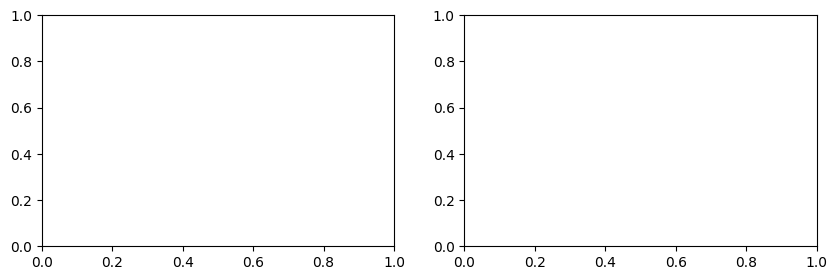

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
axs[0].plot(train_losses, label='Training loss')
axs[0].plot(valid_losses, label='Validation loss')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss vs. Epoch')

axs[1].plot(train_accs, label='Training Accuracy')
axs[1].plot(val_accs, label='Validation Accuracy')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs. Epoch')


In [11]:
def visualize_prection(testloader, model):
    random_idx = random.randint(0, len(testloader.dataset)-1)
    sample_img, sample_label = testloader.dataset[random_idx]

    # Get the model prediction
    model.eval()
    with torch.no_grad():
        pred = model(sample_img.unsqueeze(0).to(device))
        print(f"pred: {pred}")
        pred_class = torch.argmax(pred, dim=1)
        print(f"pred_class: {pred_class}")

    # Visualize the sample image
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(sample_img.permute(1, 2, 0))
    axs[1].imshow(sample_img.permute(1, 2, 0))
    axs[1].set_title(f"True Label: {get_name_from_index(sample_label)}")
    axs[0].set_title(f"Predicted Label: {get_name_from_index(pred_class)}")
    plt.show()

visualize_prection(testloader, model)


RuntimeError: running_mean should contain 64 elements not 32

In [ ]:
model.eval()

all_preds = []
all_labels = []

# Collect all predictions and true labels
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Create confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

# Create a heatmap from our confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()